# Active Learning Reproduction Demo Experiment

## Load and Process Data

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from active_learning.train import train_model, tune_weight_decay
from active_learning.evaluate import evaluate
from active_learning.active_train_loop import acquire_point_indices, active_learning
from utils.data_process import split_dataset_indices
from models.cnn import CNN
from models.cnn_baseline import CNN_baseline

# Basic config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [7]:
# Load MNIST dataset with basic transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

full_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataset_size = len(full_dataset)
print("Dataset size:", dataset_size)

Dataset size: 60000


In [8]:
# Split indices into train / pool / val / test
from utils.data_process import split_dataset_indices

splits = split_dataset_indices(
    full_dataset,
    split_size = (20, 100, 10000),
    seed = 42
)


Check if the classes are balance in the training split.

Total initial training samples: 20

Class distribution:
  Class 0: 2 samples
  Class 1: 2 samples
  Class 2: 2 samples
  Class 3: 2 samples
  Class 4: 2 samples
  Class 5: 2 samples
  Class 6: 2 samples
  Class 7: 2 samples
  Class 8: 2 samples
  Class 9: 2 samples


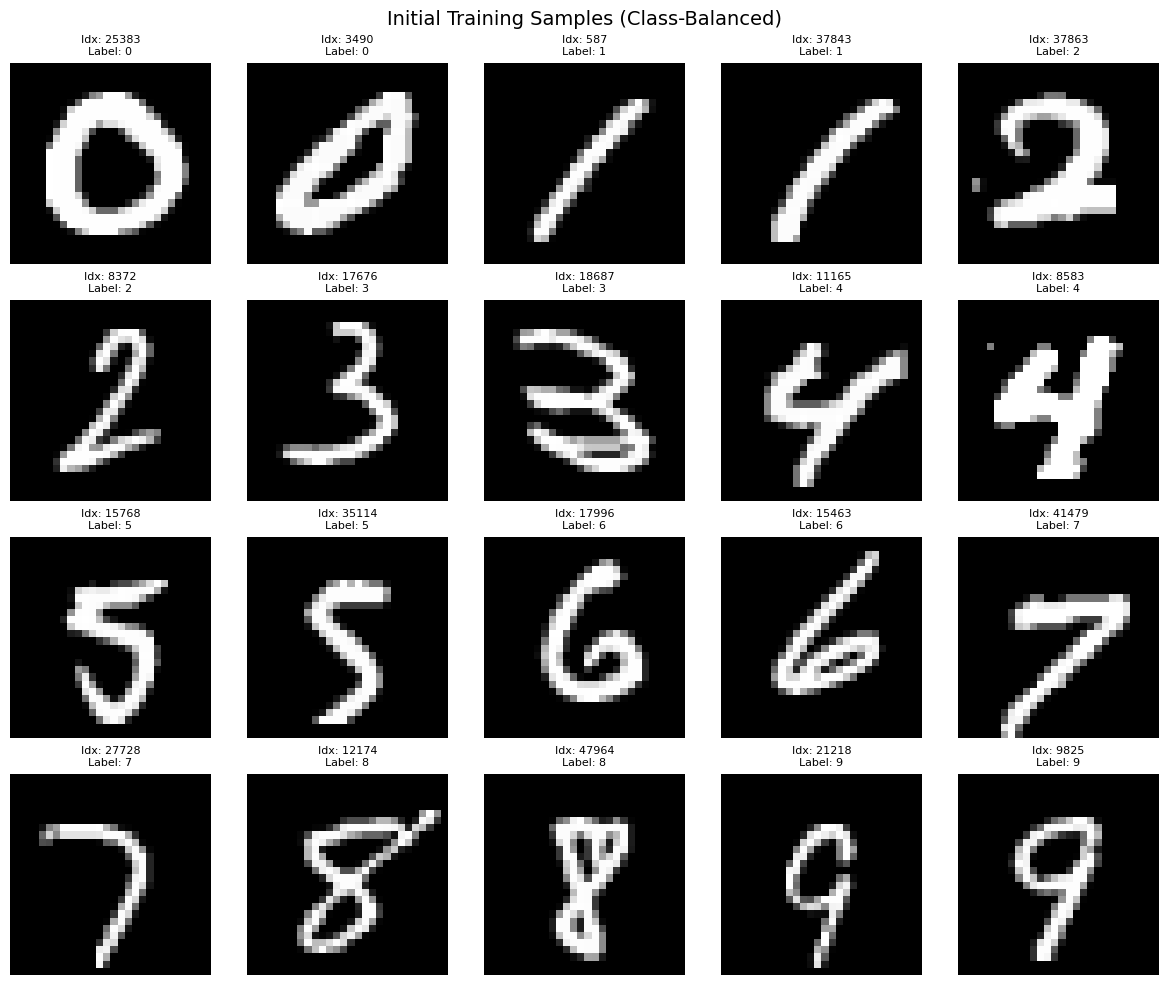

In [9]:
import matplotlib.pyplot as plt
import numpy as np

train_indices = splits["train"]
print(f"Total initial training samples: {len(train_indices)}")

label_counts = {}
for idx in train_indices:
    _, label = full_dataset[idx]
    label = int(label)
    label_counts[label] = label_counts.get(label, 0) + 1

print("\nClass distribution:")
for label in sorted(label_counts.keys()):
    print(f"  Class {label}: {label_counts[label]} samples")

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Initial Training Samples (Class-Balanced)', fontsize=14)

for i, idx in enumerate(train_indices):
    row = i // 5
    col = i % 5
    img, label = full_dataset[idx]

    if isinstance(img, torch.Tensor):
        img_np = img.squeeze().cpu().numpy()  # [H, W]
    else:
        img_np = np.array(img).squeeze()
    
    axes[row, col].imshow(img_np, cmap='gray')
    axes[row, col].set_title(f'Idx: {idx}\nLabel: {int(label)}', fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Load some existing training histories from ```Active Learning Accuracy Histories.csv```.

In [10]:
import pandas as pd
histories = pd.read_csv('Active Learning Accuracy Histories')
histories

,BALD_1,entropy_1,random_1,Var_ratios_1,mean_std_1,BALD_2,BALD_1_determ,Var_ratios_1_determ,BALD_2_determ,entropy_1_determ,...,mean_std_3,pred_cov_analytic_1_rmse,pred_cov_mfvi_1_rmse,random_1_rmse,pred_cov_analytic_2_rmse,pred_cov_mfvi_2_rmse,random_2_rmse,llSGD_varrats_1,llSGD_varrats_2,llSGD_varrats_3
0,0.5260,0.5507,0.5623,0.5322,0.5313,0.5176,0.5056,0.5019,0.4924,0.5007,...,0.5263,0.261383,0.261370,0.265632,0.265283,0.265991,0.260213,0.5215,0.5437,0.5253
1,0.5960,0.6103,0.5545,0.6007,0.5743,0.6141,0.5488,0.5016,0.5636,0.5007,...,0.5515,0.257258,0.256862,0.249840,0.257395,0.253423,0.253138,0.6138,0.6355,0.5990
2,0.6205,0.6060,0.6193,0.5982,0.6382,0.6099,0.6138,0.5540,0.6362,0.5640,...,0.5882,0.254190,0.249732,0.238886,0.256635,0.253544,0.236032,0.6665,0.6430,0.6203
3,0.6466,0.5826,0.6747,0.6044,0.6113,0.5975,0.6162,0.5826,0.5945,0.5757,...,0.6259,0.253828,0.258112,0.231761,0.257029,0.249029,0.240168,0.6946,0.6838,0.6359
4,0.6629,0.6244,0.6942,0.6370,0.6927,0.6116,0.6044,0.6477,0.6401,0.5806,...,0.6127,0.248744,0.247609,0.232571,0.246143,0.248942,0.230092,0.6821,0.6760,0.6733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.9698,0.9712,0.9484,0.9804,0.9765,0.9659,0.9550,0.9442,0.9504,0.9399,...,0.9736,0.150239,0.190779,0.110274,0.124038,0.208754,0.109935,0.9736,0.9736,0.9760
96,0.9686,0.9749,0.9424,0.9782,0.9710,0.9676,0.9532,0.9459,0.9411,0.9398,...,0.9752,0.152639,0.194435,0.109685,0.124886,0.206812,0.108886,0.9750,0.9751,0.9755
97,0.9666,0.9772,0.9497,0.9811,0.9783,0.9650,0.9517,0.9433,0.9522,0.9288,...,0.9786,0.149344,0.189638,0.109747,0.129681,0.205732,0.107571,0.9733,0.9750,0.9744
98,0.9670,0.9756,0.9524,0.9708,0.9768,0.9642,0.9504,0.9433,0.9522,0.9421,...,0.9777,0.153107,0.192406,0.110212,0.126968,0.207327,0.105333,0.9744,0.9743,0.9761


Define some helper functions to help store new training history, or to plot history results with std. error, etc.

In [ ]:
def store(hist, name, df, overwrite = False):
    '''
    Store a new accuracy history to a given dataframe, as a series with particular name.
    '''
    if name in df.columns and not overwrite:
        print(f"Saving aborted: Column '{name}' already exists in the dataframe, please use a different name. \nTo overwrite, use overwrite = True")
        return df
    df[name] = hist
    return df


def plot_mean_std(histories, keys, label, color, alpha_line=0.6, alpha_fill=0.15):
    '''
    Plot the mean and std of the given keys of histories.
    '''
    curves = np.array([histories[k] for k in keys])  # shape [num_runs, num_rounds] 
    mean = curves.mean(axis=0)
    std = curves.std(axis=0)

    x = np.arange(len(mean))

    if len(keys) == 1:
        plt.plot(x, mean, label=label, color=color, alpha=alpha_line)
    else:
        plt.fill_between(
            x,
            mean - std,
            mean + std,
            color=color,
            alpha=alpha_fill
        )

def first_exceed_index(seq, threshold):
    """
    Return the first index i where seq[i] > threshold.
    If no such index, return None.
    """
    for i, v in enumerate(seq):
        if v > threshold:
            return i
    return None

## Section 5.1: Active Learning on MNIST, Comparison of various acquisition functions

This section reproduces Section 5.1 of the original paper. In each acquisition round, we use various acquisition functions ```entropy, BALD, mean_std, variation_ratio``` to score points in the pool set (with / without MC-dropout), and acquire points with the top scores. Their learning performance is compared with random acquisition ```random```.


Implement active learning with different acquisition functions ```entropy, BALD, variation_ratio, mean_std, random```. Since MC_dropout is used to sample from posterior during both acquisition and test time, use ```MC_acquire = True```, ```MC_test = True```.

In [97]:
from active_learning.active_train_loop import active_learning

model, history = active_learning(
    dataset = full_dataset,
    acquisition_fn = "BALD",  # "entropy", "BALD", "variation_ratio", "mean_std", "random"
    split_size = (20, 100, 10000),
    random_split = True,
    model_class = CNN,
    weight_decay_candidates = [0.000001, 0.00001, 0.0001],
    n_rounds = 100,
    K = 10,
    T = 20,
    MC_acquire = True,
    MC_test = True
)

Active Learning starts, using Acquisition function BALD.  

Acquisition Round 0, |train|=20, |pool|=49880
Best weight_decay based on validation set: 1e-05
Test Accuracy: 0.5251.


KeyboardInterrupt: 

Store the new history.

In [ ]:
store(history, 'BALD_2', histories)
histories.to_csv('Active Learning Accuracy Histories', index = False)

Column 'BALD_2' already exists in the dataframe, please use a different name. Saving aborted. To overwrite, use overwrite = True


Plot some existing histories (3 histories have been stored for each acquisition function).

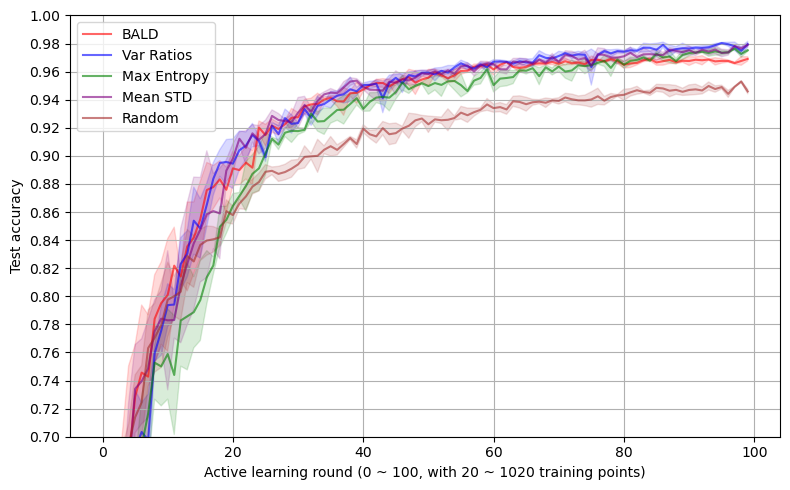

In [12]:
plt.figure(figsize=(8, 5))

plot_mean_std(
    histories,
    keys=['BALD_1', 'BALD_2', 'BALD_3'],
    label='BALD',
    color='red'
)

plot_mean_std(
    histories,
    keys=['Var_ratios_1', 'Var_ratios_2', 'Var_ratios_3'],
    label='Var Ratios',
    color='blue'
)

plot_mean_std(
    histories,
    keys=['entropy_1', 'entropy_2', 'entropy_3'],
    label='Max Entropy',
    color='green'
)

plot_mean_std(
    histories,
    keys=['mean_std_1', 'mean_std_2', 'mean_std_3'],
    label='Mean STD',
    color='purple'
)

plot_mean_std(
    histories,
    keys=['random_1', 'random_2', 'random_3'],
    label='Random',
    color='brown'
)

plt.xlabel("Active learning round (0 ~ 100, with 20 ~ 1020 training points)")
plt.ylabel("Test accuracy")
plt.ylim(0.7, 1.0)
plt.yticks(np.arange(0.7, 1.01, 0.02))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
acq_names = ['BALD', 'Var_ratios', 'entropy', 'mean_std', 'random']

for name in acq_names:
    mean_hist = (histories[name + '_1'] + histories[name + '_2'] + histories[name + '_3'])/3
    idx_90 = first_exceed_index(mean_hist, 0.90) * 10 + 5   # Since active_learning uses K=10 images per acquisition
    idx_95 = first_exceed_index(mean_hist, 0.95) * 10 + 5
    print(f"{name}: Accuracy >0.90 after acquiring {idx_90} images, >0.95 after {idx_95} images.")

BALD: Accuracy >0.90 after acquiring 245 images, >0.95 after 415 images.
Var_ratios: Accuracy >0.90 after acquiring 215 images, >0.95 after 405 images.
entropy: Accuracy >0.90 after acquiring 255 images, >0.95 after 465 images.
mean_std: Accuracy >0.90 after acquiring 215 images, >0.95 after 385 images.
random: Accuracy >0.90 after acquiring 335 images, >0.95 after 985 images.


## Section 5.2  Importance of model uncertainty

This section reproduces Section 5.2 of the original paper, implementing active Learning under Deterministic CNN (without MC dropout) using all acquisition functions ```BALD, variation_ratio, entropy```. Additionally, we conducted experiment also for ```mean_std```. Since MC dropout is neither activated during acquisition-score computations nor during test time, we simply switch to ```MC_acquire = False```, ```MC_test = False```.

Notice: turning MC_dropout off when computing acquisition functions should render ```BALD``` and ```mean_std``` useless (all scores will be approximately zero).

In [103]:
model, history = active_learning(
    dataset = full_dataset,
    acquisition_fn = "mean_std",  # "entropy", "BALD", "variation_ratio", "mean_std", "random"
    split_size = (20, 100, 10000),
    random_split = True,
    model_class = CNN,
    weight_decay_candidates = [0.000001, 0.00001, 0.0001],
    n_rounds = 100,
    K = 10,
    T = 20,
    MC_acquire = False,
    MC_test = False
)


Active Learning starts, using Acquisition function mean_std.  

Acquisition Round 0, |train|=20, |pool|=49880
Best weight_decay based on validation set: 1e-06
Test Accuracy: 0.629.
Next acquisition: Scores min = 0.0, mean = 0.0, max = 0.0 

Acquisition Round 1, |train|=30, |pool|=49870
Best weight_decay based on validation set: 0.0001
Test Accuracy: 0.6948.
Next acquisition: Scores min = 0.0, mean = 0.0, max = 0.0 

Acquisition Round 2, |train|=40, |pool|=49860
Best weight_decay based on validation set: 1e-06
Test Accuracy: 0.7069.


KeyboardInterrupt: 

In [104]:
store(history, 'mean_std_1_determ', histories) 
histories.to_csv('Active Learning Accuracy Histories', index = False)

Saving aborted: Column 'mean_std_1_determ' already exists in the dataframe, please use a different name. 
To overwrite, use overwrite = True


We make an observe that for any of the above model trained with ```MC_acquire = False```, ```MC_test = False```, simplying setting ```mc_dropout = True``` in the evaluate method below improves upon their test-time performance by 2-3% compared with setting ```mc_dropout = False```! 

This is in contrast to the empirical evidence observed by .... Here, the standard dropout during inference time (multiplying each $W_i$ by $p_i$) is does not approximate the MC dropout very well. (In short, this is because expectation can not pass through non-linear layers.)

In [107]:
test_indices = splits["test"]
acc = evaluate(model, full_dataset, test_indices, mc_dropout = True)
print(f'Test Accuracy: {acc}.')

Test Accuracy: 0.9637.


To offer a fair comparison of the issue, we additionally conduct experiment with ```MC_acquire = False, MC_test = True``` for BALD, Var Ratios, and Max Entropy. That is, the acquired points aren't exactly based on MC-computed acquisition scores, but we still test model using MC dropout.

In [22]:
model, history = active_learning(
    dataset = full_dataset,
    acquisition_fn = "mean_std",  # "entropy", "BALD", "variation_ratio", "mean_std", "random"
    split_size = (20, 100, 10000),
    random_split = True,
    model_class = CNN,
    weight_decay_candidates = [0.000001, 0.00001, 0.0001],
    n_rounds = 100,
    K = 10,
    T = 20,
    MC_acquire = False,
    MC_test = False
)

Active Learning starts, using Acquisition function mean_std.  

Acquisition Round 0, |train|=20, |pool|=49880


KeyboardInterrupt: 

In [253]:
store(history, 'mean_std_1_determ_testMC', histories) 
histories.to_csv('Active Learning Accuracy Histories', index = False)

Now we can plot Figure 2 in the original paper. Select the type of acquisition function below and click run.

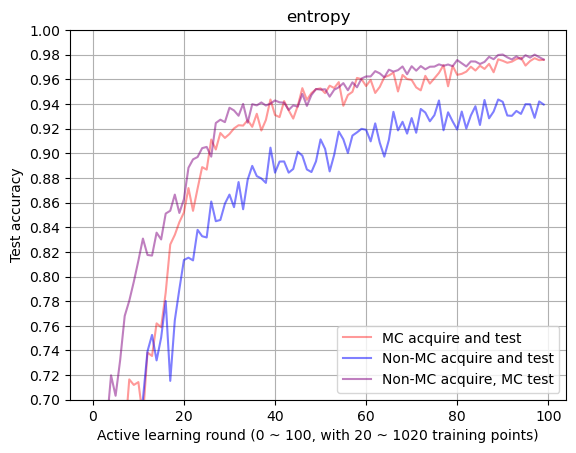

In [14]:
type = 'entropy'    # Select between 'BALD', 'Var_ratios', 'entropy', 'mean_std', 'random'

hist_mc = histories[type+'_1']  # History of model with MC_aquire = True, MC_test = True
hist_determ = histories[type+'_1_determ']  # History of model with MC_acquire = False, MC_test = False
hist_determ_testMC = histories[type+'_1_determ_testMC']  # History of model with MC_acquire = False, MC_test = True

plt.plot(hist_mc, label = 'MC acquire and test', c = 'red', alpha = 0.4)
plt.plot(hist_determ, label = 'Non-MC acquire and test', c = 'blue', alpha = 0.5)
plt.plot(hist_determ_testMC, label = 'Non-MC acquire, MC test', c = 'purple', alpha = 0.5)
plt.title(type)
plt.xlabel("Active learning round (0 ~ 100, with 20 ~ 1020 training points)")
plt.ylabel("Test accuracy")
plt.ylim(0.7, 1.0)
plt.yticks(np.arange(0.7, 1.01, 0.02))
plt.grid(True)
plt.legend()
plt.show()


We make the following observation: Using non-random acquisition functions in general reduce the number of samples the oracle needs to label to help model achieve a certain test accuracy level. However, given the model is trained using dropout, carrying out MC dropout (/model averaging) during test time leads to significantly better performance that using standard dropout (to scaling all neurons at test time by dropout probability). This is regardless of whether the model is trained with MC-dropout-acquired data. 

In particular, standard dropout during inference time (multiplying each $W_i$ by $p_i$) is does not approximate the MC-dropout very well. Intuitively, this is because expectation can not pass through non-linear layers.

## Section 5.3. Baseline Comparison with Analytic (/MFVI) inference.

This section conducts the baseline extension, conduct active learning, treating the classification task as a regression task. In each round, unlabelled data from the pool with the highest predictive covariance are acquired. The predictive variance are calculated using 2 different approaches: Analytic inference ```pred_cov_analytic```, ```pred_cov_mfvi```. Their resulting learning performance is compared with random acquisition ```random```.

In [ ]:
from active_learning.active_train_loop_baseline import active_learning_baseline

model, history = active_learning_baseline(
    dataset=full_dataset,
    acquisition_fn="random", # Select between "pred_cov_analytic", "pred_cov_mfvi", "random"
    split_size=(20, 100, 10000),
    random_split=True,
    n_rounds=100,
    K=10,
    s_sq = 10,
    num_iterations = 50,
    lr = 0.001,
)

Active Learning Baseline starts, using Acquisition function random.  

Acquisition Round 0, |train|=20, |pool|=49880
Best weight_decay based on validation RMSE: 1e-06
Test RMSE: 0.260213.
Acquisition Round 1, |train|=30, |pool|=49870
Best weight_decay based on validation RMSE: 1e-06
Test RMSE: 0.253138.
Acquisition Round 2, |train|=40, |pool|=49860
Best weight_decay based on validation RMSE: 1e-05
Test RMSE: 0.236032.
Acquisition Round 3, |train|=50, |pool|=49850
Best weight_decay based on validation RMSE: 1e-05
Test RMSE: 0.240168.
Acquisition Round 4, |train|=60, |pool|=49840
Best weight_decay based on validation RMSE: 1e-05
Test RMSE: 0.230092.
Acquisition Round 5, |train|=70, |pool|=49830
Best weight_decay based on validation RMSE: 1e-06
Test RMSE: 0.212650.
Acquisition Round 6, |train|=80, |pool|=49820
Best weight_decay based on validation RMSE: 0.0001
Test RMSE: 0.207266.
Acquisition Round 7, |train|=90, |pool|=49810
Best weight_decay based on validation RMSE: 0.0001
Test RMSE: 0

In [75]:
test_indices = splits["test"]
acc = evaluate(model, full_dataset, test_indices, mc_dropout = False)
print(f'Test Accuracy: {acc}.')

Test Accuracy: 0.9637.


For fair comparison, we also test the final test accuracy (not only RMSE) for the baseline models (training viewing the last layer as regression). In computing accuracy, we simply output the highest-value class as the predicted class.

* For pred_cov_analytic_1_rmse inference (s_sq = 2/128), the final RMSE is around 0.150, and the test accuracy is 0.9233.
* For pred_cov_analytic_2_rmse inference (s_sq = 10), the final RMSE is around 0.127, and the test accuracy is 0.965.
* For pred_cov_mfvi_1_rmse inference (s_sq = 2/128), the final RMSE is around 0.193, and the test accuracy is 0.8021.
* For pred_cov_mfvi_2_rmse inference (s_sq = 10), the final RMSE is around 0.2163, and the test accuracy is 0.7052.
* For random_1_rmse inference, the final RMSE is around 0.110, and the test accuracy is 0.967.
* For random_2_rmse inference, the final RMSE is around 0.109, and the test accuracy is 0.9637

The larger the scale of ```s_sq```, the wider the prior.

In [76]:
store(history, 'random_2_rmse', histories, overwrite=True) 
histories.to_csv('Active Learning Accuracy Histories', index = False)

In [77]:
histories

,BALD_1,entropy_1,random_1,Var_ratios_1,mean_std_1,BALD_2,BALD_1_determ,Var_ratios_1_determ,BALD_2_determ,entropy_1_determ,...,mean_std_2,random_2,random_3,mean_std_3,pred_cov_analytic_1_rmse,pred_cov_mfvi_1_rmse,random_1_rmse,pred_cov_analytic_2_rmse,pred_cov_mfvi_2_rmse,random_2_rmse
0,0.5260,0.5507,0.5623,0.5322,0.5313,0.5176,0.5056,0.5019,0.4924,0.5007,...,0.5356,0.5734,0.5801,0.5263,0.261383,0.261370,0.265632,0.265283,0.265991,0.260213
1,0.5960,0.6103,0.5545,0.6007,0.5743,0.6141,0.5488,0.5016,0.5636,0.5007,...,0.6066,0.6807,0.6140,0.5515,0.257258,0.256862,0.249840,0.257395,0.253423,0.253138
2,0.6205,0.6060,0.6193,0.5982,0.6382,0.6099,0.6138,0.5540,0.6362,0.5640,...,0.5991,0.7018,0.6691,0.5882,0.254190,0.249732,0.238886,0.256635,0.253544,0.236032
3,0.6466,0.5826,0.6747,0.6044,0.6113,0.5975,0.6162,0.5826,0.5945,0.5757,...,0.6564,0.6963,0.6687,0.6259,0.253828,0.258112,0.231761,0.257029,0.249029,0.240168
4,0.6629,0.6244,0.6942,0.6370,0.6927,0.6116,0.6044,0.6477,0.6401,0.5806,...,0.7252,0.7126,0.6758,0.6127,0.248744,0.247609,0.232571,0.246143,0.248942,0.230092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.9698,0.9712,0.9484,0.9804,0.9765,0.9659,0.9550,0.9442,0.9504,0.9399,...,0.9698,0.9509,0.9478,0.9736,0.150239,0.190779,0.110274,0.124038,0.208754,0.109935
96,0.9686,0.9749,0.9424,0.9782,0.9710,0.9676,0.9532,0.9459,0.9411,0.9398,...,0.9749,0.9425,0.9477,0.9752,0.152639,0.194435,0.109685,0.124886,0.206812,0.108886
97,0.9666,0.9772,0.9497,0.9811,0.9783,0.9650,0.9517,0.9433,0.9522,0.9288,...,0.9779,0.9493,0.9488,0.9786,0.149344,0.189638,0.109747,0.129681,0.205732,0.107571
98,0.9670,0.9756,0.9524,0.9708,0.9768,0.9642,0.9504,0.9433,0.9522,0.9421,...,0.9751,0.9538,0.9527,0.9777,0.153107,0.192406,0.110212,0.126968,0.207327,0.105333


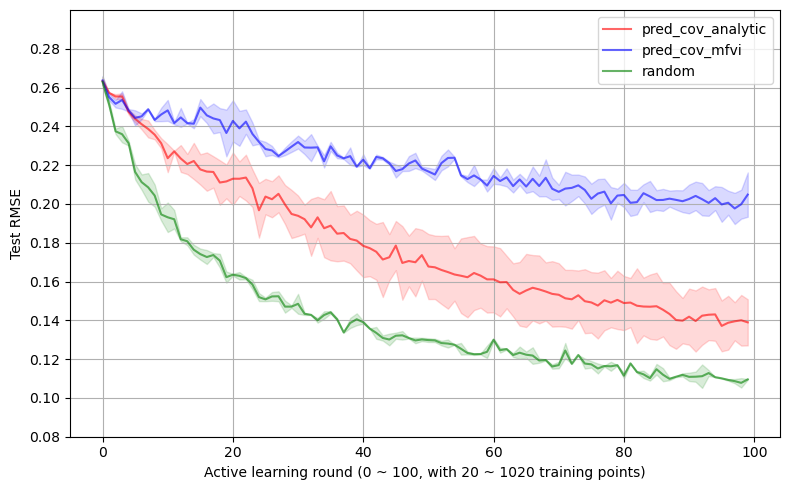

In [15]:
plt.figure(figsize=(8, 5))

plot_mean_std(
    histories,
    keys=['pred_cov_analytic_1_rmse', 'pred_cov_analytic_2_rmse'],
    label='pred_cov_analytic',
    color='red'
)

plot_mean_std(
    histories,
    keys=['pred_cov_mfvi_1_rmse', 'pred_cov_mfvi_2_rmse'],
    label='pred_cov_mfvi',
    color='blue'
)

plot_mean_std(
    histories,
    keys=['random_1_rmse', 'random_2_rmse'],
    label='random',
    color='green'
)

plt.xlabel("Active learning round (0 ~ 100, with 20 ~ 1020 training points)")
plt.ylabel("Test RMSE")
plt.ylim(0.08, 0.30)
plt.yticks(np.arange(0.08, 0.30, 0.02))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Interestingly, random acquisition beats both ```pred_cov_analytic``` and ```pred_cov_mfvi```.

## Section 5.4.1: Further Extension 1: Langevin-based Adaptive Basis Selective Sampling

Instead of treating final layer as a regression task, one can view it still as classfication task. Train a model (with weight decay), then freeze all layers up to the last layer and use the network as a feature extractor. Starting from the trained optimal parameters of the last layer, independently run SGD to train $T$ heads, and treat the models obtained from SGD sampling as posterior samples. Note that the SGD objective should include the same weight decay as in the original model. The initial learning rate $\alpha_0 (= 1.0)$ can be specified manually, and the subsequent learning rate follow a Robbins–Monro type schedule $\alpha_s = \alpha_0 / (10s + 1000)$. Finally, these $T$ heads are attached back to the feature extractor and regard them as $T$ posterior-sampled models, which are then used to compute the prediction probability vector for each data point in the pool set.

The above design is supported by 3 major reasons:  
* it captures the epistemic uncertainty in prediction resulting from high feature multi-collinearity in the last layer features.
* it is not a variational approach. Without assuming a specific form of the weight posterior, this method derived from SGLD results in a more faithful representation of the posterior.
* it is computationally feasible and provably stable due to the log-concavity of the loss landscape.


1. There are severe multi-collinearity between the 128 learned features, which results in high uncertainty in final layer's weight estimation (generalizing a standard fact from linear regression), leading to epistemic uncertainty in prediction. Capturing the uncertainty within the weight learning process allows us to quantify the epistemic uncertainty in predictions.

To see the multi-collinearity, we train a ```cnn_baseline``` and compute the **Variance Inflation Factor (VIF)** for each of its penultimate layer's 128 features. VIF measures how much the variance of a feature's coefficient increases due to collinearity with others, and is defined as $1/(1-r^2)$, where $r^2$ is the $r^2$ coef. of regressing this feature against the rest. 

Training Complete. Test Accuracy: 0.7535
Computing VIF for feature 0...
Computing VIF for feature 10...
Computing VIF for feature 20...
Computing VIF for feature 30...
Computing VIF for feature 40...
Computing VIF for feature 50...
Computing VIF for feature 60...
Computing VIF for feature 70...
Computing VIF for feature 80...
Computing VIF for feature 90...
Computing VIF for feature 100...
Computing VIF for feature 110...
Computing VIF for feature 120...


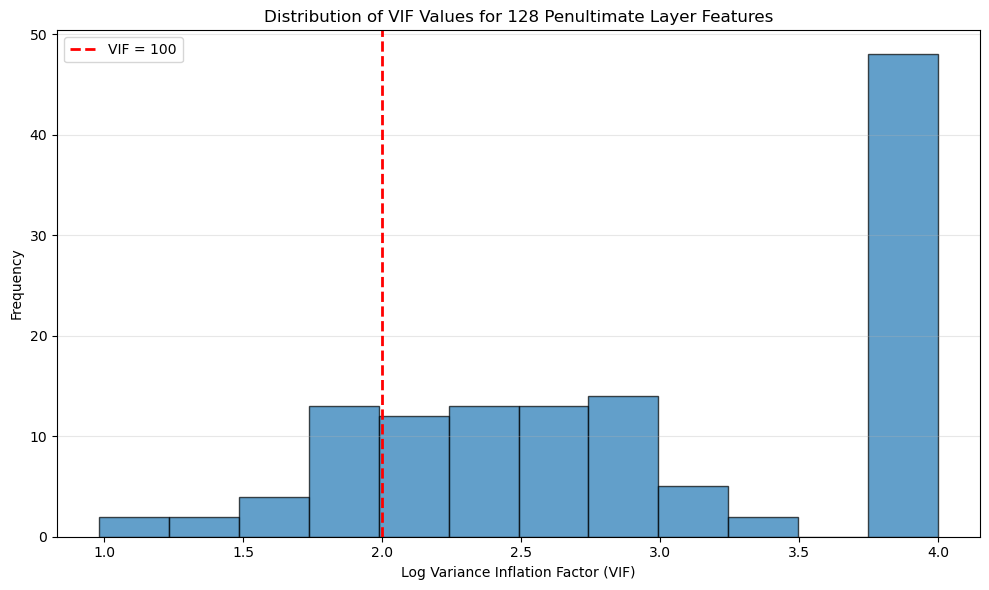

Features with VIF>10: 127. Min VIF: 9.563187361273723, Max VIF: 10000.0


In [53]:
# Train CNN_baseline and compute VIF for penultimate layer features
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from models.cnn_baseline import CNN_baseline
from active_learning.train import train_model, tune_weight_decay

val_indices = splits["val"]
test_indices = splits["test"]

# Train model
model = train_model(CNN_baseline, full_dataset, val_indices, 0.0001,
                    num_epochs=100, criterion='accuracy', device=DEVICE)
print(f"Training Complete. Test Accuracy: {evaluate(model, full_dataset, test_indices, mc_dropout=False):.4f}")

# Extract features from full_dataset
model.eval()
features_list = []
with torch.no_grad():
    loader = torch.utils.data.DataLoader(full_dataset, batch_size=64, shuffle=False)
    for images, _ in loader:
        features_list.append(model.get_feature(images.to(DEVICE)).cpu())
features = torch.cat(features_list, dim=0).numpy()

# Extract: Compute VIF for each feature
features_std = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
vifs = np.zeros(128)
for i in range(128):
    y = features_std[:, i]
    X = np.delete(features_std, i, axis=1)
    if i % 10 == 0:
        print(f'Computing VIF for feature {i}...')
    r_squared = LinearRegression(fit_intercept=False).fit(X, y).score(X, y)
    vifs[i] = 1.0 / (1.0 - r_squared) if r_squared < 0.9999 else 10000
log_vifs = np.log10(vifs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(log_vifs, bins=12, edgecolor='black', alpha=0.7)
plt.axvline(x = 2, color='r', linestyle='--', linewidth=2, label='VIF = 100')
plt.xlabel('Log Variance Inflation Factor (VIF)')
plt.ylabel('Frequency')
plt.title('Distribution of VIF Values for 128 Penultimate Layer Features')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Features with VIF>10: {np.sum(vifs > 10)}. Min VIF: {np.min(vifs)}, Max VIF: {np.max(vifs)}")




The above uncertainty can be captured by training SGDs, starting around the optimized last layer weights.

2. Adopting an SGLD-based approach (SGD is similar to SGLD as described in section...), this offers a way to sample from the *exact* model posterior $p(W|D)$, not having to carry out variational optimization (like ELBO) to fit a special parametrizable form as the *approximate* posterior, which offers huge advantage. We note the previous mfvi and analytic inference methods on the last layer did not perform well due to their unrealistic assumption about the posterior form for the layer weights (e.g. independence and etc.), as well as their assumption made about the output distribution $p(y|w, \Phi) $, which none is needed for SGD-based approach on final layer.

3. There are theoretical justifications for carrying out uncertainty inference only on the last layer. The SGD training on last layer is not heavy compared with full-network SGD. Moreover, since the likelihood landscape $p(w|D) = p(D|w) p(W)$ is log-concave, the Robbins-Monro type schedule for SGD on the log-space enjoys stability. There are also additional theoretical justification for initiating SGD from local optimal (cold_start = False) to explore the posterior landscape...

In [17]:
from active_learning.active_train_lastlayer import active_learning_lastlayer    

In [ ]:
model, history = active_learning_lastlayer(
    full_dataset,
    acquisition_fn="mean_std_heads", # var_rat_heads, (mean_std_heads,  BALD_heads under development)
    split_size=(20, 100, 10000),  # Initial_training, Validation, Test_set size
    random_split=False,
    weight_decay_candidates=[0.000001, 0.00001, 0.0001],
    n_rounds=100,
    K=10,
    T=10,  # Number of heads to train (posterior samples)
    alpha_0=0.01,  # Initial learning rate for Robbins-Monro schedule
    num_iterations=1000,  # Number of SGD iterations per head
    batch_size=64,
    device="cuda",
    cold_start = False,
    langevin = False
)

Active Learning Last Layer starts, using Acquisition function mean_std_heads.  

Acquisition Round 0, |train|=20, |pool|=49880
Best weight_decay based on validation accuracy: 1e-06
Extracting training features...
Training 10 heads with SGD (Robbins-Monro schedule, initialized from optimal (Langevin dynamics))...
Trained head 1/10 (initialized from optimal (Langevin))
Trained head 2/10 (initialized from optimal (Langevin))
Trained head 3/10 (initialized from optimal (Langevin))
Trained head 4/10 (initialized from optimal (Langevin))
Trained head 5/10 (initialized from optimal (Langevin))
Trained head 6/10 (initialized from optimal (Langevin))
Trained head 7/10 (initialized from optimal (Langevin))
Trained head 8/10 (initialized from optimal (Langevin))
Trained head 9/10 (initialized from optimal (Langevin))
Trained head 10/10 (initialized from optimal (Langevin))
Test Accuracy: 0.539500.
Next acquisition: Scores min = 2.8755395287127783e-10, mean = 0.12586230039596558, max = 0.230793148

KeyboardInterrupt: 

In [58]:
store(history, 'llSGD_varrats_3', histories, overwrite=False) 
histories.to_csv('Active Learning Accuracy Histories', index = False)

In [60]:
histories

,BALD_1,entropy_1,random_1,Var_ratios_1,mean_std_1,BALD_2,BALD_1_determ,Var_ratios_1_determ,BALD_2_determ,entropy_1_determ,...,mean_std_3,pred_cov_analytic_1_rmse,pred_cov_mfvi_1_rmse,random_1_rmse,pred_cov_analytic_2_rmse,pred_cov_mfvi_2_rmse,random_2_rmse,llSGD_varrats_1,llSGD_varrats_2,llSGD_varrats_3
0,0.5260,0.5507,0.5623,0.5322,0.5313,0.5176,0.5056,0.5019,0.4924,0.5007,...,0.5263,0.261383,0.261370,0.265632,0.265283,0.265991,0.260213,0.5215,0.5437,0.5253
1,0.5960,0.6103,0.5545,0.6007,0.5743,0.6141,0.5488,0.5016,0.5636,0.5007,...,0.5515,0.257258,0.256862,0.249840,0.257395,0.253423,0.253138,0.6138,0.6355,0.5990
2,0.6205,0.6060,0.6193,0.5982,0.6382,0.6099,0.6138,0.5540,0.6362,0.5640,...,0.5882,0.254190,0.249732,0.238886,0.256635,0.253544,0.236032,0.6665,0.6430,0.6203
3,0.6466,0.5826,0.6747,0.6044,0.6113,0.5975,0.6162,0.5826,0.5945,0.5757,...,0.6259,0.253828,0.258112,0.231761,0.257029,0.249029,0.240168,0.6946,0.6838,0.6359
4,0.6629,0.6244,0.6942,0.6370,0.6927,0.6116,0.6044,0.6477,0.6401,0.5806,...,0.6127,0.248744,0.247609,0.232571,0.246143,0.248942,0.230092,0.6821,0.6760,0.6733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.9698,0.9712,0.9484,0.9804,0.9765,0.9659,0.9550,0.9442,0.9504,0.9399,...,0.9736,0.150239,0.190779,0.110274,0.124038,0.208754,0.109935,0.9736,0.9736,0.9760
96,0.9686,0.9749,0.9424,0.9782,0.9710,0.9676,0.9532,0.9459,0.9411,0.9398,...,0.9752,0.152639,0.194435,0.109685,0.124886,0.206812,0.108886,0.9750,0.9751,0.9755
97,0.9666,0.9772,0.9497,0.9811,0.9783,0.9650,0.9517,0.9433,0.9522,0.9288,...,0.9786,0.149344,0.189638,0.109747,0.129681,0.205732,0.107571,0.9733,0.9750,0.9744
98,0.9670,0.9756,0.9524,0.9708,0.9768,0.9642,0.9504,0.9433,0.9522,0.9421,...,0.9777,0.153107,0.192406,0.110212,0.126968,0.207327,0.105333,0.9744,0.9743,0.9761


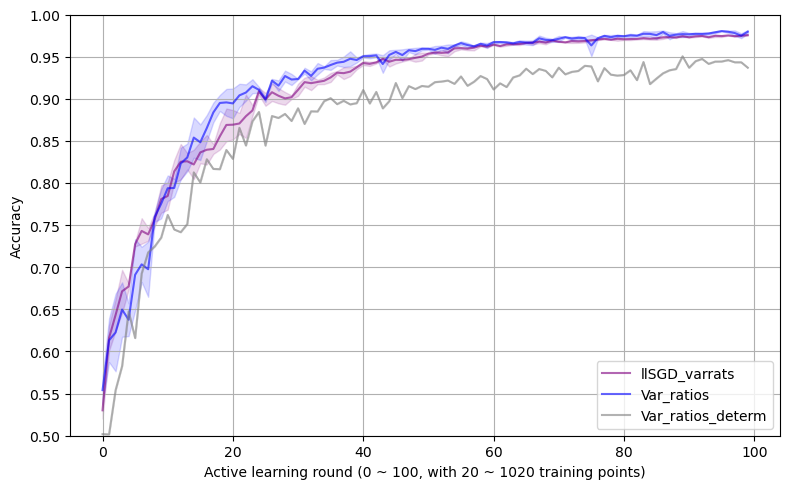

In [40]:
plt.figure(figsize=(8, 5))

plot_mean_std(
    histories,
    keys=['llSGD_varrats_1', 'llSGD_varrats_2', 'llSGD_varrats_3'],
    label='llSGD_varrats',
    color='purple'
)

plot_mean_std(
    histories,
    keys=['Var_ratios_1', 'Var_ratios_2', 'Var_ratios_3'],
    label='Var_ratios',
    color='blue'
)

plot_mean_std(
    histories,
    keys=['Var_ratios_1_determ'],
    label='Var_ratios_determ',
    color='gray'
)



plt.xlabel("Active learning round (0 ~ 100, with 20 ~ 1020 training points)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Last layer SGD produces good performance at the beginning since it captures the last-layer feature-usage (which learned features to use) level uncertainty well. Later in the training phase however (from 13th round onwards), deeper uncertainty (e.g. what features to learn) arising from earlier feature-extractor layers kick in, and llSGD (llSGD_varrats) is slightly outperformed by the MC-dropout approach (Var_ratios). 

This points to a temporal hierarchical uncertainty learning pipeline, modelling uncertainty of a deep model architecture from output level gradually towards the input source.

## Section 5.4.2:  Extension 2: Dropout-inspired model-averaging comparison

We observe that performing standard dropout at test time leads to poorer performance than doing MC_dropout for the digit classification task. We prove a small lemma to slightly elaborate this fact. 

Denote $\theta$ the model parameters, $p_\theta$ the Bernoulli dropout distribution over model parameters, so that each set of edge weights $\{\theta^i_{km}\}_{m=1,...,\ell_{i-1}}$ connecting to neuron $k$ in layer $i$ from the previous layer are dropped together with probability $p_i$. Let $\omega \sim p_\theta$ be the parameter realizations so that $f_\omega$ is the realized model instance with $\omega$ as parameter, $f_\omega(x)$ the prediction, $y$ the target, and $\mathcal L$ the loss. For ease of analysis, let us assume both training and test data follow $p_{data}$. 

Then, training the model using dropout minimizes 

$$\mathcal{L_{MCdrop}} = \mathbb E_{(x,y)\sim p_{data}, \omega \sim p_\theta} [ \mathcal L(f_\omega(x), y)],$$

On the other hand, evaluating the model at test time with standard dropout is equivalent to evaluating

$$\mathcal{L_{stddrop}} = \mathbb E_{(x,y)\sim p_{data}} [ \mathcal L(f_{\bar \omega}(x), y)],$$

where $\bar \omega = E_{\omega \sim p_\theta}\omega$. This is also known as model averaging. It is clear that these two objectives do not align. In fact, under some circumstances, using standard dropout inevitably leads to worse performance than Monte Carlo dropout.

**Lemma** : When $f_\omega$ is linear in $\omega$, and $L$ is strictly concave in its first argument, $\mathcal{L_{MCdrop}} < \mathcal{L_{stddrop}}$. 

**Remark**: When $\omega \sim p_\theta$ only has uncertainty on the last weight layer, and no softmax or other non-linear prediction head is attached, $f_\omega$ is (approximately) linear in $\omega$. For example, consider a simple multi-target regression task with uncertainty on last layer weights with MSE loss, the above Lemma says doing MC dropout strictly outperforms standard dropout.
